In [0]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display
import pandas as pd
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
np.random.seed(115)

max_itr = 40
############################################  READ  ##########################################################
# PLEASE NOTE I AM LOADING MY DATA IN COLAB THROUGH MOUNTING MY OWN DRIVE WHICH CONTAINS FOLDERS THE FOLLOWING:
# 170049
# 170161
# 170301

Mounted at /content/drive


In [0]:
############### LOAD DARA THROUGH GOOGLE DRIVE (MINE)
labels = pd.read_csv("/content/drive/My Drive/all_audio/labels.csv")
labels = np.array(labels)
labels[np.where(labels=='SPEECH')]=0
labels[np.where(labels=='MUSIC')]=1
labels[np.where(labels=='DOORKNOCK')]=2
labels[np.where(labels=='DOORCLOSE')]=3

np.random.shuffle(labels)
tr_n = int(0.8*labels.shape[0])
f_train = labels[0:tr_n,0]
y_train = labels[0:tr_n,1]
f_test = labels[tr_n:,0]
y_test = labels[tr_n:,1] 

sr = 15000
h = int(sr * 0.01)
w = int(sr * 0.025)
nfft=2048
N = 7000
x_train = []
for f in f_train:
    wav, sr1 = librosa.core.load('/content/drive/My Drive/all_audio/{}'.format(f),sr=sr,duration=10)
    wav = wav[np.arange(0,wav.shape[0],10)] #skipping 10 samples assuming no significant info is stored there
    x_train.append(np.abs(librosa.core.stft(wav[N:],hop_length=h,win_length=w,n_fft=nfft)))
x_train = np.array(x_train)

x_test = []
for f in f_test:
    wav, sr1 = librosa.core.load('/content/drive/My Drive/all_audio/{}'.format(f),sr=sr,duration=10)
    wav = wav[np.arange(0,wav.shape[0],10)]
    x_test.append(np.abs(librosa.core.stft(wav[N:],hop_length=h,win_length=w,n_fft=nfft)))
x_test = np.array(x_test)


In [0]:
def PLCA_classifier_trainer(x, y):
    x = x.reshape((x.shape[0],x.shape[1]*x.shape[2]))
    b = 10**-100
    
    x0 = x[np.where(y==0)].T
    x1 = x[np.where(y==1)].T
    x2 = x[np.where(y==2)].T
    x3 = x[np.where(y==3)].T

    Wf = []

    K = 5

    W = np.random.rand(x0.shape[0],K)
    H = np.random.rand(K,x0.shape[1])
    Q = np.zeros((K,x0.shape[0],x0.shape[1]))
    Q = Q.astype(float)

    for n in range(max_itr):
        for i in range(W.shape[1]):
            Q[i] = W[:,i].reshape(W.shape[0],1) @ H[i].reshape(1,H.shape[1])
            Q[i] /= ((W @ H) + b)
        for i in range(W.shape[1]):
            H[i] = (x0 * Q[i]).sum(axis=0)
            W[:,i] = (x0.T * Q[i].T).sum(axis=0)
        H = (H/(H.T.sum(axis=1) + b))
        W = (W/(W.T.sum(axis=1) + b))

    Wf.append(W)

    W = np.random.rand(x1.shape[0],K)
    H = np.random.rand(K,x1.shape[1])
    Q = np.zeros((K,x1.shape[0],x1.shape[1]))
    Q = Q.astype(float)

    for n in range(max_itr):
        for i in range(W.shape[1]):
            Q[i] = W[:,i].reshape(W.shape[0],1) @ H[i].reshape(1,H.shape[1])
            Q[i] /= ((W @ H) + b)
        for i in range(W.shape[1]):
            H[i] = (x1 * Q[i]).sum(axis=0)
            W[:,i] = (x1.T * Q[i].T).sum(axis=0)
        H = (H/(H.T.sum(axis=1) + b))
        W = (W/(W.T.sum(axis=1) + b))

    Wf.append(W)

    W = np.random.rand(x2.shape[0],K)
    H = np.random.rand(K,x2.shape[1])
    Q = np.zeros((K,x2.shape[0],x2.shape[1]))
    Q = Q.astype(float)

    for n in range(max_itr):
        for i in range(W.shape[1]):
            Q[i] = W[:,i].reshape(W.shape[0],1) @ H[i].reshape(1,H.shape[1])
            Q[i] /= ((W @ H) + b)
        for i in range(W.shape[1]):
            H[i] = (x2 * Q[i]).sum(axis=0)
            W[:,i] = (x2.T * Q[i].T).sum(axis=0)
        H = (H/(H.T.sum(axis=1) + b))
        W = (W/(W.T.sum(axis=1) + b))

    Wf.append(W)

    W = np.random.rand(x3.shape[0],K)
    H = np.random.rand(K,x3.shape[1])
    Q = np.zeros((K,x3.shape[0],x3.shape[1]))
    Q = Q.astype(float)

    for n in range(max_itr):
        for i in range(W.shape[1]):
            Q[i] = W[:,i].reshape(W.shape[0],1) @ H[i].reshape(1,H.shape[1])
            Q[i] /= ((W @ H) + b)
        for i in range(W.shape[1]):
            H[i] = (x3 * Q[i]).sum(axis=0)
            W[:,i] = (x3.T * Q[i].T).sum(axis=0)
        H = (H/(H.T.sum(axis=1) + b))
        W = (W/(W.T.sum(axis=1) + b))

    Wf.append(W)
    
    return np.array(Wf)

In [0]:
def PLCA_classifier(x, W):
    x = x.reshape((1,x.shape[0]*x.shape[1])).T
    b = 10**-100

    H = np.random.rand(4,W.shape[2],1)  

    for q in range(4):
        Q = np.zeros((W.shape[2],x.shape[0],x.shape[1]))
        Q = Q.astype(float)

        for n in range(max_itr):
            for i in range(W[q].shape[1]):
                Q[i] = W[q][:,i].reshape(W[q].shape[0],1) @ H[q][i].reshape(1,H[q].shape[1])
                Q[i] /= ((W[q] @ H[q]) + b)
            for i in range(W[q].shape[1]):
                H[q][i] = (x * Q[i]).sum(axis=0)
            H[q] = (H[q]/(H[q].T.sum(axis=1) + b))

    pred = 0
    for i in range(1,4):
        if np.linalg.norm(x-(W[i] @ H[i])) < np.linalg.norm(x-(W[pred] @ H[pred])):
            pred = i
    
    return pred


CLASSIFICATION ACCURACY FOR PLCA : 50.0

#################### CONFUSION MATRIX FOR PLCA CLASSIFICATION ####################

[[2 0 0 1]
 [0 7 1 0]
 [1 0 1 4]
 [0 1 4 2]]

#################### 5 basis vectors for PLCA classification of 0 ####################



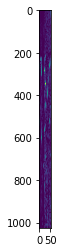

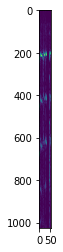

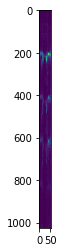

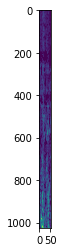

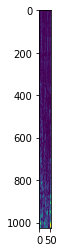


#################### 5 basis vectors for PLCA classification of 1 ####################



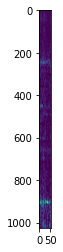

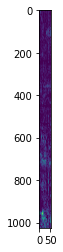

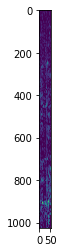

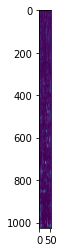

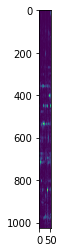


#################### 5 basis vectors for PLCA classification of 2 ####################



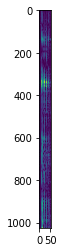

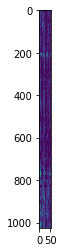

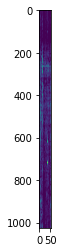

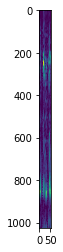

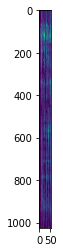


#################### 5 basis vectors for PLCA classification of 3 ####################



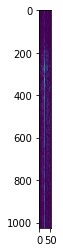

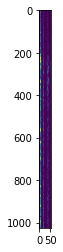

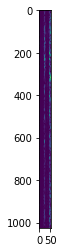

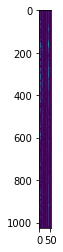

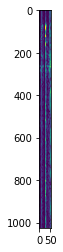

In [0]:
y_pred=[]
W = PLCA_classifier_trainer(x_train,y_train)
for i in range(x_test.shape[0]):
    y_pred.append(PLCA_classifier(x_test[i],W))
y_pred = np.array(y_pred)
print("\nCLASSIFICATION ACCURACY FOR PLCA :",100*(((y_test==y_pred).sum())/y_test.shape[0]))
CM = np.zeros((4,4))
for i in range(y_test.shape[0]):
    CM[y_test[i],y_pred[i]] += 1
print("\n#################### CONFUSION MATRIX FOR PLCA CLASSIFICATION ####################\n")
print(CM.astype(int))

for n in range(4):
    print("\n#################### 5 basis vectors for PLCA classification of {} ####################\n".format(n))
    for i in range(W.shape[2]):
        plt.imshow(W[n,:,i].reshape((x_train.shape[1],x_train.shape[2])))
        plt.show()
